<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/nutr__all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ②f_nutr1シートのE_CR～E_SSまでの１７食品群別エネルギー<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

In [3]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [4]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [5]:
# # 特定の変数と他の変数との相関を確認
# def targetCorrMatrix(df):
#   df = 'VEG3'
#   correlations = values_dataframe.corrwith(values_dataframe[df])
#   correlations.sort_values(ascending=False)

In [6]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [9]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [10]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [11]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [12]:
print(len(data_nutr),len(data_fnutr1))

3329 3347


## ↓idの重複削除、結合

In [13]:
# data_fnutr1重複を確認
print("data_fnutr1 で重複のある行数:", data_fnutr1['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_fnutr1 で重複のある行数: 136
data_nutr で重複のある行数: 116


In [14]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [15]:
# 左結合
merged_data = pd.merge(data_fnutr1, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 9.0+ MB
None


In [16]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

136

In [17]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
3211


In [18]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3302
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 8.6+ MB
None
3211


### ↓変数作成


In [19]:
## エネルギー補正係数とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加(ECF:Energy correction factor)
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['ECF'] = cleaned_data_copy['EER'] / cleaned_data_copy['EN']

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,W_CR,W_PT,W_SG,W_PL,W_GV,W_OV,W_FR,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,ECF
0,201100005,2015.0,11,303.195981,27.717256,8.135054,144.377205,145.014042,111.979363,268.098456,...,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,22.340297,1.231252


In [20]:
# 変数を選択
selected_columns = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].copy()
selected_columns['BMI'] = cleaned_data_copy['BMI']
selected_columns['ECF'] = cleaned_data_copy['ECF']
selected_columns['AGE'] = cleaned_data_copy['AGE']
selected_columns['SEX'] = cleaned_data_copy['SEX']
values_dataframe = selected_columns

values_dataframe.describe()

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF,AGE,SEX
count,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.571548,50.411233,18.212708,73.328395,32.447372,38.622535,45.711714,145.961651,137.943696,62.759368,143.407969,96.285807,179.458348,120.820796,54.307191,22.312986,1.255976,47.716963,1.606061
std,367.152819,44.818075,14.877232,54.599812,22.708942,25.633737,46.285147,122.277501,87.598725,40.147394,122.020847,53.547513,162.579887,177.117455,36.027271,3.649318,0.476263,22.889282,0.488698
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,0.259846,10.000000,1.000000
25%,495.650412,17.691071,7.812617,30.781927,16.613035,20.654462,12.303194,63.145533,82.901157,35.060232,56.324967,59.048827,62.329747,19.529291,29.027599,19.735976,0.952504,25.000000,1.000000
50%,666.067491,42.551282,15.032625,61.333836,27.118384,33.100241,32.739018,111.759260,126.005859,56.948571,116.335714,88.581030,137.361087,46.464286,46.618420,21.953125,1.168960,53.000000,2.000000
75%,851.336016,69.686258,24.072308,105.481068,42.860439,50.234088,63.991357,191.924707,169.401280,90.432496,193.928571,126.588080,245.750421,130.637962,73.753514,24.444444,1.441831,67.000000,2.000000
max,5202.143086,330.233334,141.620005,432.728702,177.452680,178.625893,431.759097,1192.206400,951.942218,253.210990,1234.340143,588.183023,1672.645467,2011.630053,261.886802,50.781250,5.894433,96.000000,2.000000


In [21]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

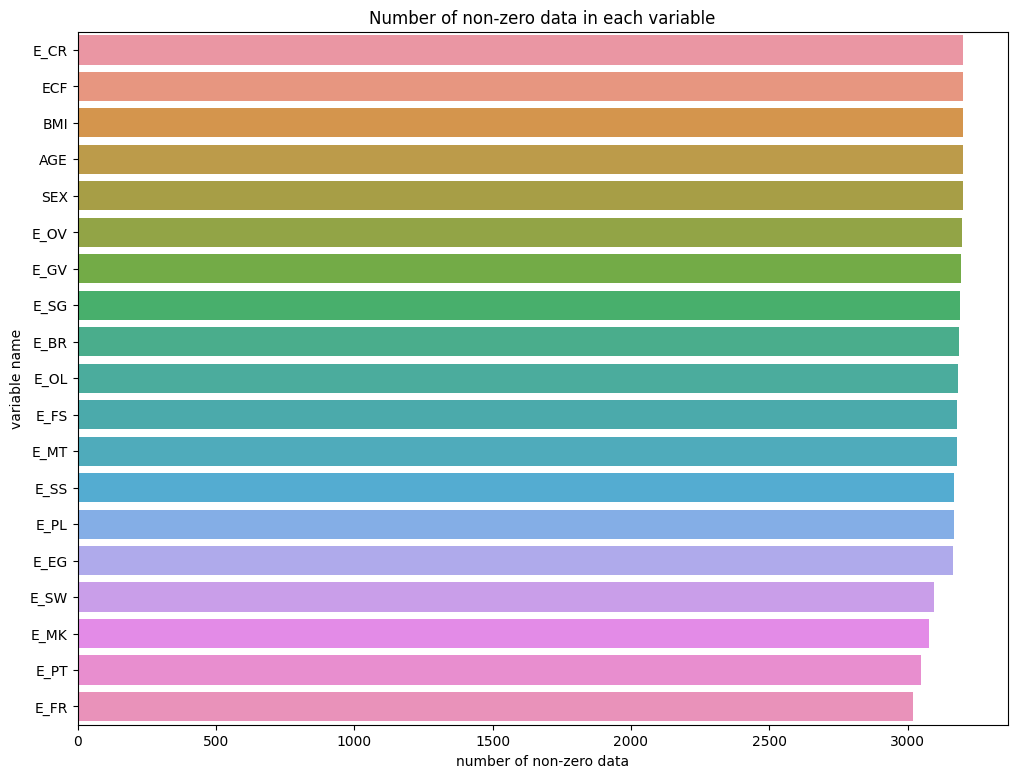

('E_GV', 'E_OV', 0.7040129248500424)
('E_GV', 'E_FR', 0.567757844868274)
('E_OV', 'E_GV', 0.7040129248500424)
('E_FR', 'E_GV', 0.567757844868274)
('E_MT', 'E_OL', 0.5948509316936996)
('E_OL', 'E_MT', 0.5948509316936996)


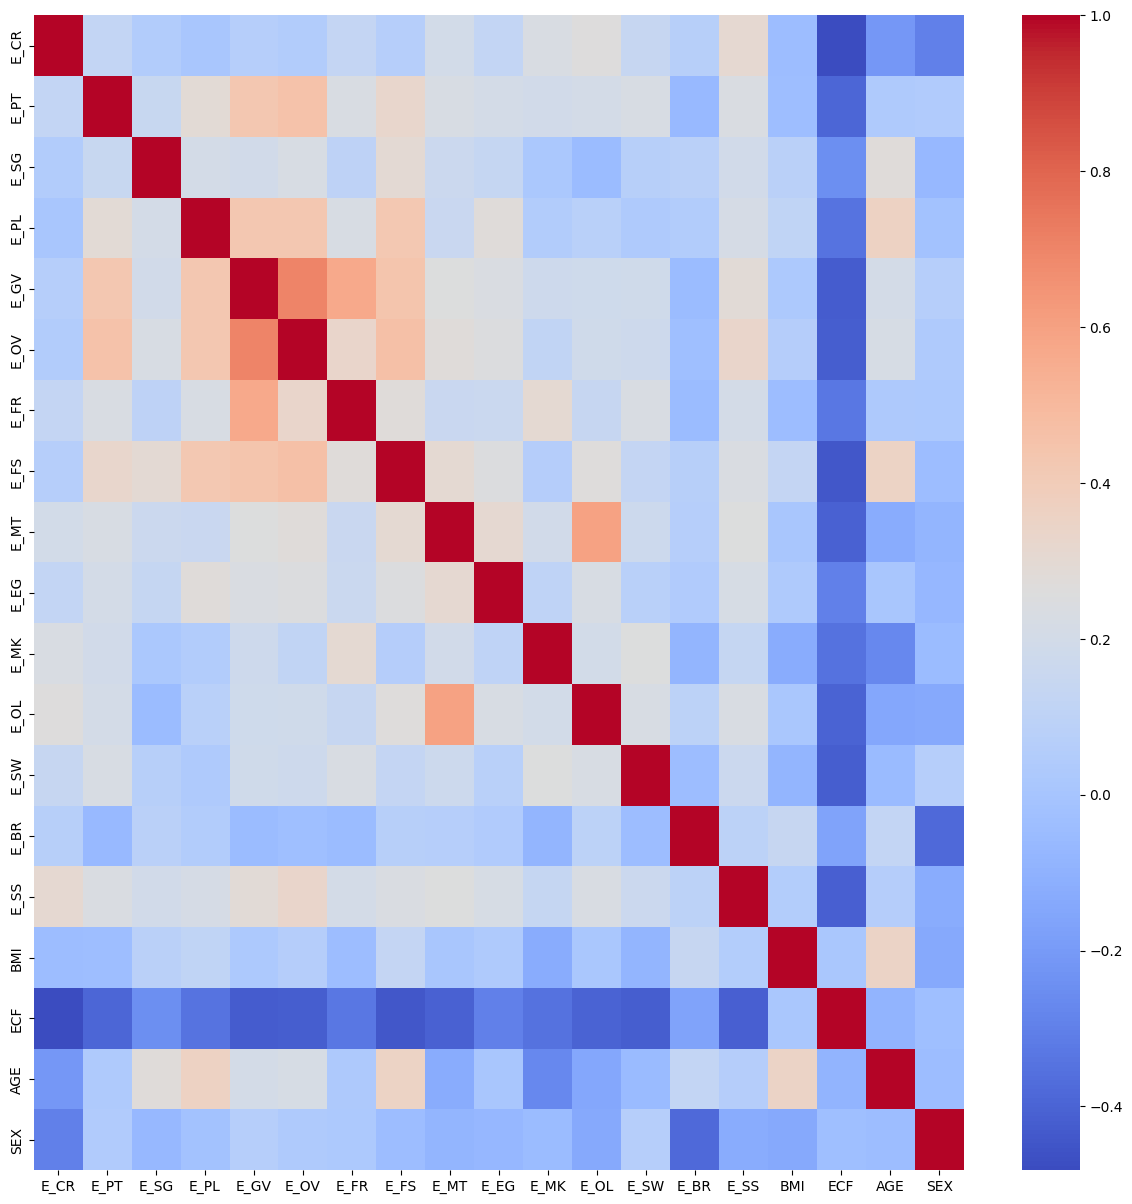

In [22]:
checksVariables(values_dataframe_cleaned)

### LiNGAMの関数定義

In [23]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [24]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(f"推定した因果モデルにおける、誤差同士の独立性のp値\n{p_values}\n\n")

  return model

In [25]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [26]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    causal_df = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    causal_df['from'] = causal_df['from'].apply(lambda x: labels[x])
    causal_df['to'] = causal_df['to'].apply(lambda x: labels[x])
    return causal_df

In [27]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [28]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF', 'AGE', 'SEX']


In [ ]:
# 変数を指定するリスト(16)
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

In [ ]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

In [ ]:
# ECF列を掛ける
multiplied_df_filtered = df_filtered.drop('ECF', axis=1).multiply(df_filtered['ECF'], axis=0)
# print(multiplied_df_filtered.describe())
checksVariables(multiplied_df_filtered)

In [ ]:
dot,causal_df = LiNGAM(multiplied_df_filtered,'nutr_all_data_allvar')
dot

In [ ]:
causal_df

## 8変数

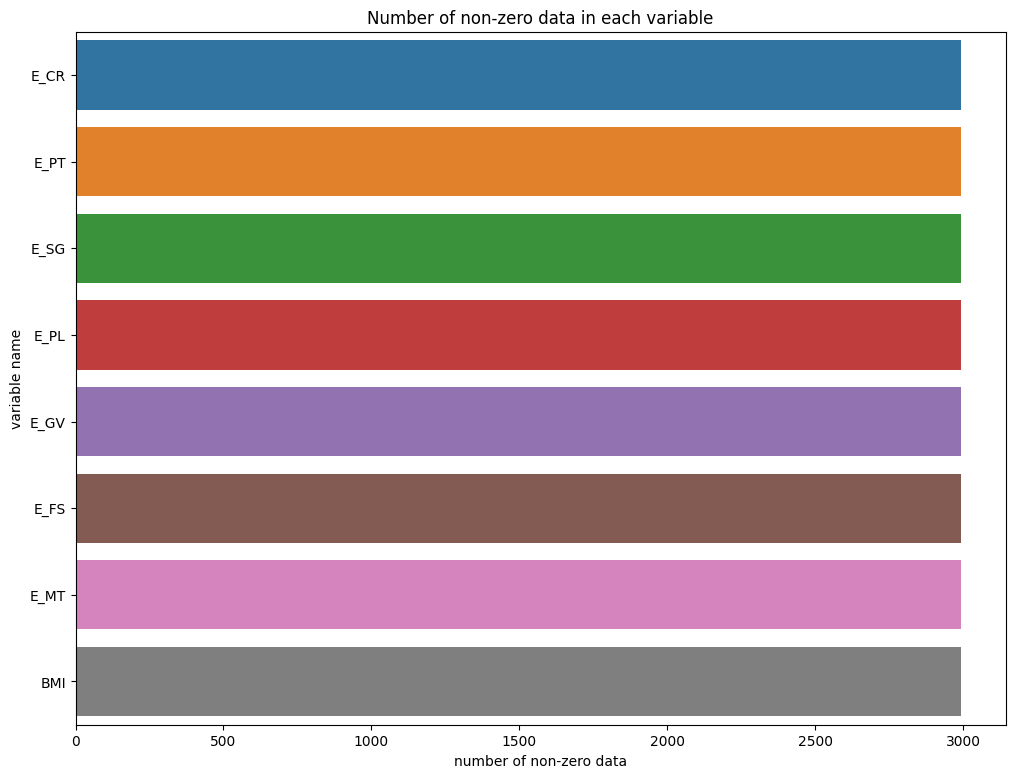

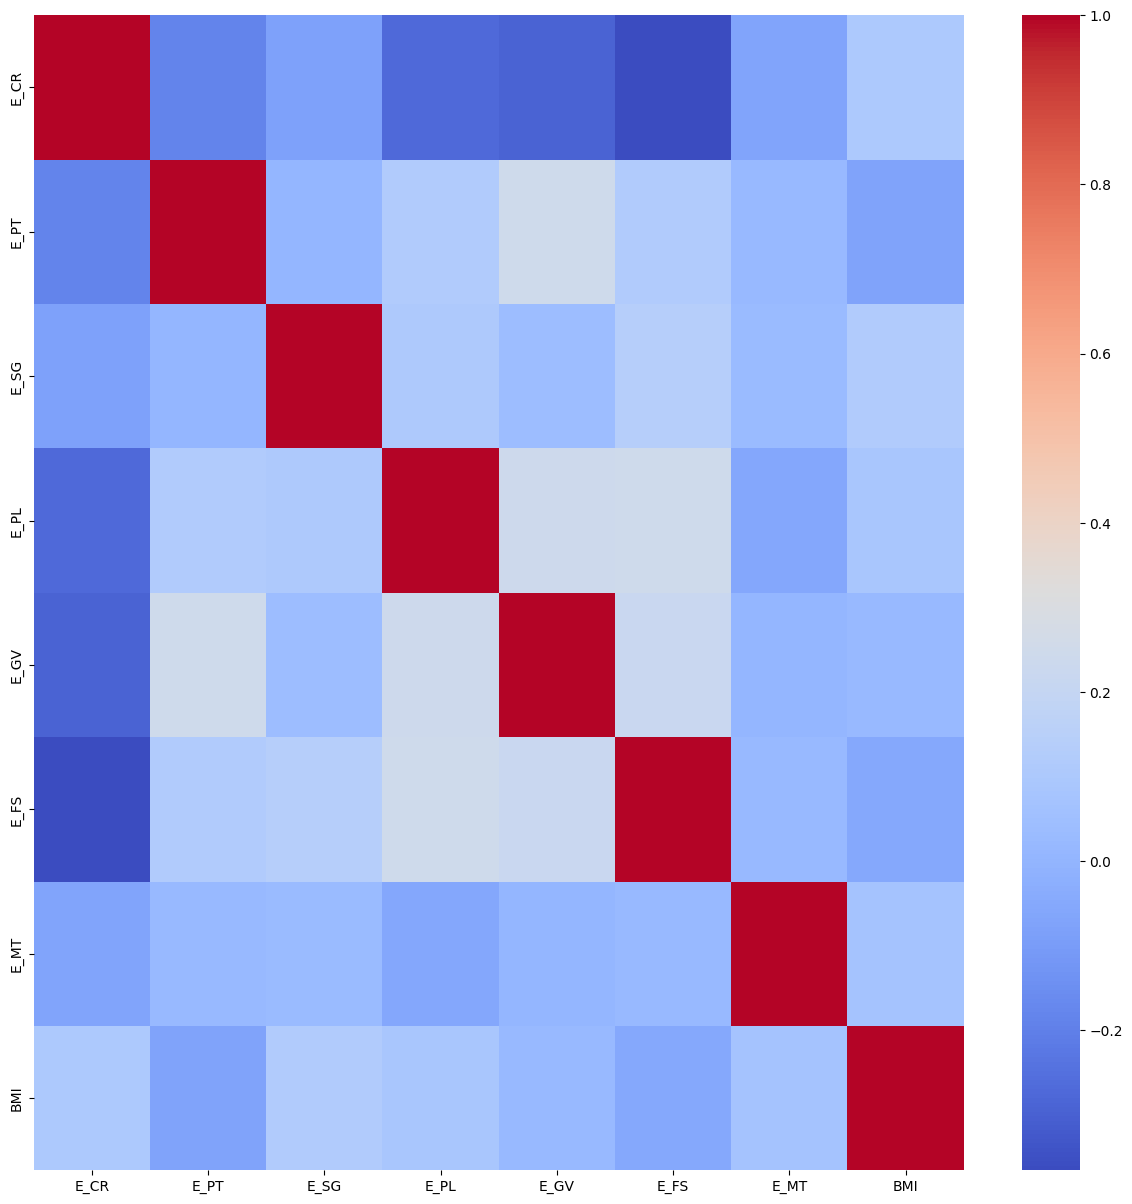

因果の順番
[5, 4, 6, 2, 3, 7, 1, 0]


隣接行列
[[ 0.         -0.07587756  0.         -0.16027934 -0.16989328 -0.24486002
  -0.05437247  0.11921851]
 [ 0.          0.          0.          0.05783832  0.22268185  0.05616901
   0.         -0.08157273]
 [ 0.          0.          0.          0.          0.          0.13741096
   0.          0.        ]
 [ 0.          0.          0.07318073  0.          0.21165769  0.18754996
  -0.0676133   0.        ]
 [ 0.          0.          0.          0.          0.          0.18753221
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.11922007  0.05025689  0.         -0.09682638
   0.07841623  0.        ]]


推定した因果モデルにおける、誤差同士の独立性のp値
[[0.00000000e+00 7.50035024e-02 9.08148710e-02 1.56915302e-01
  8.74217126e-04 7.56669375e-03 1.38769744e-03 2.60515370e-07]
 [7.50035024e-02

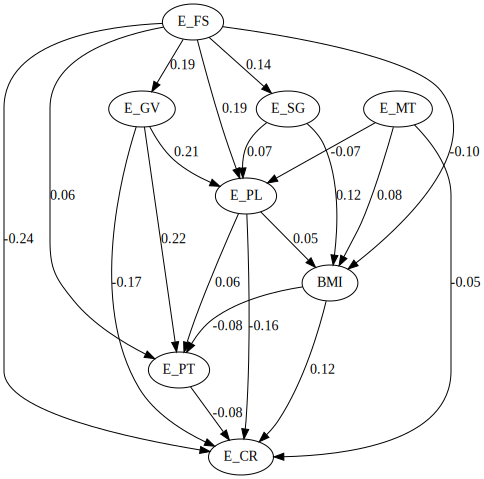

In [36]:
# 変数を指定するリスト(8)
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_FS', 'E_MT', 'BMI', 'ECF']
df = values_dataframe_cleaned[selected_variables]
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]
# ECF列を掛ける
multiplied_df_filtered = df_filtered.drop('ECF', axis=1).multiply(df_filtered['ECF'], axis=0)
checksVariables(multiplied_df_filtered)
dot,causal_df = LiNGAM(multiplied_df_filtered,'nutr_all_data_8var')
dot

In [35]:
causal_df

,from,to,effect,probability
0,E_BR,E_MK,-0.158564,1.00
1,E_SS,E_OV,0.132987,1.00
2,E_BR,E_FR,-0.117980,1.00
3,E_BR,E_OV,-0.125703,1.00
4,E_FS,E_SG,0.143794,1.00
...,...,...,...,...
190,E_GV,E_MT,0.074713,0.01
191,E_MK,E_MT,-0.057868,0.01
192,E_CR,E_SS,0.074107,0.01
193,E_PL,E_FS,0.177845,0.01
